In [1]:
import pandas as pd
import json
import math as m
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import collections
import re
import networkx as nx
import nltk
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import TruncatedSVD
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
data_json = []
with open('data/dblp-ref-0.json') as f:
    for line in f:
        data_json.append(json.loads(line))
with open('data/dblp-ref-1.json') as f:
    for line in f:
        data_json.append(json.loads(line))
with open('data/dblp-ref-2.json') as f:
    for line in f:
        data_json.append(json.loads(line))
with open('data/dblp-ref-3.json') as f:
    for line in f:
        data_json.append(json.loads(line))

In [3]:
df = pd.DataFrame(data_json)

In [4]:
df = df[df['abstract'].notnull()]

In [5]:
train_df = df.head(100000).copy()

In [6]:
parentdomain = {
    "coding theory" : "mathematical foundations",
    "game theory" : "mathematical foundations",
    "graph theory" : "mathematical foundations",
    "mathematical logic" : "mathematical foundations",
    "boolean logic" : "mathematical foundations",
    "number theory" : "mathematical foundations",
    "mathematical foundations" : "mathematical foundations",
    "algorithms" : "algorithms and data structures",
    "data structures" : "algorithms and data structures",
    "algorithms and data structures" : "algorithms and data structures",
    "automated reasoning" : "artificial intelligence",
    "computer vision" : "artificial intelligence",
    "machine learning" : "artificial intelligence",
    "evolutionary computing" : "artificial intelligence",
    "natural language processing" : "artificial intelligence",    
    "artificial intelligence" : "artificial intelligence",
    "neural network" : "artificial intelligence",
    "speech processing" : "artificial intelligence",
    "information retrieval" : "artificial intelligence",
    "data mining" : "artificial intelligence",
    "robotics" : "artificial intelligence",
    "networking" : "communication and security",
    "computer networks" : "communication and security",
    "communication networks" : "communication and security",
    "cryptography" : "communication and security",
    "communication and security" : "communication and security",
    "network protocols" : "communication and security",
    "network attacks" : "communication and security",
    "operating systems" : "computer architecture",
    "computer architecture" : "computer architecture",
    "image processing" : "computer graphics",
    "information visualization" : "computer graphics",
    "visualization" : "computer graphics",
    "visualisation" : "computer graphics",
    "computer graphics" : "computer graphics",
    "parallel computing" : "concurrent, parallel, and distributed systems",
    "concurrency" : "concurrent, parallel, and distributed systems",
    "distributed computing" : "concurrent, parallel, and distributed systems",
    "concurrent, parallel, and distributed systems" : "concurrent, parallel, and distributed systems",
    "relational databases" : "databases",
    "structured storage" : "databases",
    "databases" : "databases",
    "compiler theory" : "programming languages and compilers",
    "programming language" : "programming languages and compilers",
    "programming language pragmatics" : "programming languages and compilers",
    "programming language theory" : "programming languages and compilers",
    "formal semantics" : "programming languages and compilers",
    "type theory" : "programming languages and compilers",
    "programming languages and compilers" : "programming languages and compilers",
    "computational science" : "scientific computing",
    "numerical analysis" : "scientific computing",
    "symbolic computation " : "scientific computing",
    "computational physics" : "scientific computing",
    "computational chemistry" : "scientific computing",
    "bioinformatics" : "scientific computing",
    "computational biology" : "scientific computing",
    "computational neuroscience" : "scientific computing",
    "scientific computing" : "scientific computing",
    "formal methods" : "software engineering",
    "algorithm design" : "software engineering",
    "computer programming" : "software engineering",
    "human–computer interaction" : "software engineering",
    "reverse engineering" : "software engineering",
    "software engineering" : "software engineering",
    "automata theory " : "theory of computation",
    "computability theory" : "theory of computation",
    "computational complexity theory" : "theory of computation",
    "quantum computing" : "theory of computation",
    "theory of computation" : "theory of computation",   
}

In [7]:
df_copy = train_df.copy()
def getdomainlist(row):
    abst = row['abstract'] if type(row['abstract']) != float else  ""
    venue = row['venue'] if type(row['venue']) != float else  ""
    
    text = abst + " " + row['title'] + " " + venue
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    output1 = list(ngrams(tokens, 1))
    output2 = list(ngrams(tokens, 2))
    output3 = list(ngrams(tokens, 3))
    output = []
    for words in output1:
        output.append(' '.join(words))
    for words in output2:
        output.append(' '.join(words))
    for words in output3:
        output.append(' '.join(words))
    domainlist = set()
    for word in output:
        if word in parentdomain:
            domainlist.add(parentdomain[word])
    if len(domainlist) > 0:
        return list(domainlist)[0]
    else:
        return ""

df_copy['domain'] = df_copy.apply(getdomainlist, axis = 1)

In [8]:
dffinal = df_copy[df_copy['domain'].map(lambda x: len(x) >0)]

In [9]:
dffinal['text'] = dffinal[['abstract', 'title', 'venue']].apply(lambda x: ' '.join(x), axis=1)

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(dffinal['text'].head(50000), dffinal['domain'].head(50000), random_state = 0)

pipeline = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge'))
                     ])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=10,
                               verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 120 out of 120 | elapsed:  6.0min finished
/jet/var/python/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (5,), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(dffinal['text'].head(50000), dffinal['domain'].head(50000), random_state = 0)
# class TextSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, field):
#         self.field = field
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.field]

# def Tokenizer(str_input):
#     words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
#     porter_stemmer=nltk.PorterStemmer()
#     words = [porter_stemmer.stem(word) for word in words]
#     return words

# classifier = Pipeline([
#             ('colext', TextSelector('text')),
#             ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
#                      min_df=.0025, max_df=0.25, ngram_range=(1,3))),
#             ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
#     ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
# #    ('clf', RandomForestClassifier()),
#     ])

# parameters = {
# #     'vect__max_df': (0.5, 0.75, 1.0),
# #     # 'vect__max_features': (None, 5000, 10000, 50000),
# #     'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
# #     # 'tfidf__use_idf': (True, False),
# #     # 'tfidf__norm': ('l1', 'l2'),
# #     'clf__max_iter': (5,),
# #     'clf__alpha': (0.00001, 0.000001),
# #     'clf__penalty': ('l2', 'elasticnet'),
#     # 'clf__max_iter': (10, 50, 80),
# }

# grid_search = GridSearchCV(clas, parameters, cv=5,n_jobs=10,
#                                verbose=1)
# grid_search.fit(X_train, y_train)

In [11]:
df['text'] = df[['abstract', 'title', 'venue']].apply(lambda x: ' '.join(x), axis=1)

In [23]:
df[df['id'] == '7bb71afa-91b8-46e7-9008-da84e0427b93']

,abstract,authors,id,n_citation,references,title,venue,year,text,domain


In [12]:
len(df)

2548532

In [13]:
#tdf = df.head(1500000).copy()

In [14]:
answer = grid_search.predict(df['text'].values.tolist())

In [15]:
df['domain'] = answer.tolist()

In [16]:
pidtod = {}
def domains(row):
    pidtod[row['id']] = row['domain']
        
x = df.apply(domains, axis = 1)

In [17]:
pidtoyear = {}
def getyear(row):
    pidtoyear[row['id']] = row['year']
        
x = df.apply(getyear, axis = 1)

In [19]:
paperid = df['id'].values.tolist()
papernames = df['title'].values.tolist()
paperref = df['references'].values.tolist()
paperidmap = {}
paperidtoname = {}
paperindextoid = {}
g=nx.DiGraph()
for index, i in enumerate(paperid):
    paperidmap[i] = index
    paperindextoid[index] = i
    paperidtoname[i] = papernames[index]
    
ptop = {}
for i in range(len(paperid)):
    ptop[paperid[i]] = paperref[i]


for key in ptop.keys():
    t = set()
    if type(ptop[key]) == list:
        for i in ptop[key]:
            if i in paperidmap and pidtod[i] == pidtod[key]:
                g.add_edge(paperidmap[key],paperidmap[i])

In [20]:
len(ptop)

2548532

In [24]:
# paperid1 = tdf['id'].values.tolist()
# papernames1 = tdf['title'].values.tolist()
# paperref1 = tdf['references'].values.tolist()
# paperidmap1 = {}
# paperidtoname1 = {}
# paperindextoid1 = {}
g1=nx.DiGraph()
# for index, i in enumerate(paperid1):
#     paperidmap1[i] = index
#     paperindextoid1[index] = i
#     paperidtoname1[i] = papernames1[index]
    
# ptop1 = {}
# for i in range(len(paperid1)):
#     ptop[paperid1[i]] = paperref1[i]


for key in ptop.keys():
    t = set()
    if type(ptop[key]) == list:
        for i in ptop[key]:
            if i in paperidmap:
                g1.add_edge(paperidmap[key],paperidmap[i])

In [25]:
pr = nx.pagerank(g, alpha=0.85)

In [26]:
pr1 = nx.pagerank(g1, alpha=0.85)

In [27]:
answer = sorted(pr.items(), key=lambda kv: kv[1], reverse = True)

In [28]:
answer1 = sorted(pr1.items(), key=lambda kv: kv[1], reverse = True)

In [211]:
improv_pr = pd.DataFrame(answer1).rename(columns = {0:'index',1:'score'})

In [212]:
improv_pr['index'] = paperindextoid[]

,index,score
0,349209,8.014744e-04
1,2021108,4.139026e-04
2,1996630,4.038459e-04
3,2073988,2.780486e-04
4,2334546,2.652912e-04
5,1744678,2.567116e-04
6,1754789,2.554936e-04
7,1569802,2.473109e-04
8,1541012,2.365198e-04
9,1821217,2.325486e-04


In [214]:
for elem in answer[:20]:
    print(paperidtoname[paperindextoid[elem[0]]])

Genetic Algorithms in Search, Optimization and Machine Learning
LIBSVM: A library for support vector machines
Distinctive Image Features from Scale-Invariant Keypoints
Probabilistic Reasoning in Intelligent Systems: Networks of Plausible Inference
Random Forests
C4.5: Programs for Machine Learning
A theory for multiresolution signal decomposition: the wavelet representation
A fast and elitist multiobjective genetic algorithm: NSGA-II
Fuzzy identification of systems and its applications to modeling and control
Compressed sensing
Snakes: Active Contour Models
A Tutorial on Support Vector Machines for Pattern Recognition
Capacity of multi-antenna Gaussian channels
The Design and Analysis of Computer Algorithms
The WEKA data mining software: an update
Induction of Decision Trees
Genetic algorithms + data structures=evolution programs
A method for obtaining digital signatures and public-key cryptosystems
The Concept of a Linguistic Variable and its Application to Approximate Reasoning-I
His

In [30]:
top100papers = answer[:100]


In [31]:
pidtocitationyears = {}
for p in paperid:
    year = pidtoyear[p]
    if type(ptop[p]) == list: 
        for rp in ptop[p]:
            if rp in paperidmap:
                rid = paperidmap[rp]
                if rid not in pidtocitationyears:
                    pidtocitationyears[rid] = {}

                if year not in pidtocitationyears[rid]:
                    pidtocitationyears[rid][year] = 1
                else:
                    pidtocitationyears[rid][year] += 1


In [32]:
for p in top100papers:
    print(p[0], pidtocitationyears[p[0]])

349209 {2017: 116, 2013: 621, 2012: 649, 2011: 804, 2008: 834, 2001: 409, 2004: 581, 2005: 711, 2000: 358, 2010: 825, 2006: 745, 1998: 344, 1999: 296, 2002: 441, 1991: 22, 1992: 33, 2014: 533, 2009: 898, 1990: 18, 1996: 154, 2003: 517, 1997: 212, 2007: 873, 1994: 107, 2015: 428, 1993: 54, 2016: 326, 1995: 121, 1989: 5, 1988: 2}
2021108 {2014: 1468, 2011: 1016, 2010: 860, 2013: 1428, 2012: 1244, 2003: 42, 2005: 199, 2007: 472, 2009: 689, 2008: 512, 2006: 296, 2004: 87, 2015: 1734, 2016: 1600, 2017: 510, 2002: 15, 2001: 3, 2000: 2}
1996630 {2012: 1590, 2010: 1429, 2014: 1512, 2011: 1496, 2007: 598, 2013: 1691, 2016: 1576, 2006: 406, 2009: 1153, 2015: 1721, 2008: 871, 2005: 176, 2017: 504, 2004: 30, 2003: 3}
2073988 {2013: 315, 2012: 312, 2002: 232, 2006: 314, 1991: 58, 1995: 99, 2011: 374, 2010: 408, 2005: 307, 2000: 171, 1999: 137, 1997: 129, 1998: 121, 1989: 18, 2014: 265, 2003: 209, 2004: 245, 1990: 54, 2008: 377, 2001: 183, 2007: 397, 1993: 83, 2009: 399, 1994: 90, 1996: 116, 2016: 1

In [168]:
countyearsofpapers = collections.defaultdict(int)
for p in top100papers:
    countyearsofpapers[p[0]] = len(pidtocitationyears[p[0]])

In [169]:
countyearsofpapers = pd.DataFrame.from_dict(countyearsofpapers, orient = 'index').reset_index()

In [170]:
countyearsofpapers = countyearsofpapers.rename(columns={'index': 'domain', 0: 'frequency'})
countyearsofpapers = countyearsofpapers.sort_values(by=['frequency'], ascending = False)

In [171]:
countyearsofpapers.head(10)

,domain,frequency
83,1716188,49
13,354312,45
29,1074048,43
18,2054367,42
21,2046094,41
17,711061,40
96,1150683,38
70,283828,38
36,1903243,37
42,1380237,36


In [172]:
pidtod[paperindextoid[1716188]]

'artificial intelligence'

In [173]:
paperidtoname[paperindextoid[1716188]]

'Nearest neighbor pattern classification'

In [174]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[1716188], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})

In [175]:
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)

In [177]:
yeartocitations = yeartocitations.drop([41])

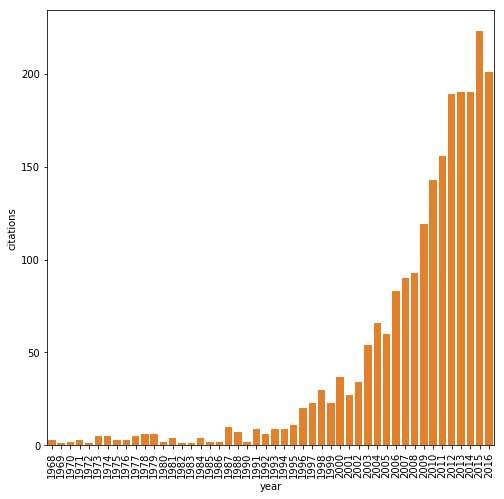

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8 ,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

          Fig: Citations of the paper 'Nearest neighbor 
        pattern classification' (Artificial Intelligence)

In [187]:
pidtod[paperindextoid[1074048]]

'artificial intelligence'

In [188]:
paperidtoname[paperindextoid[1074048]]

'Textural Features for Image Classification'

In [189]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[1074048], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})

In [190]:
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)

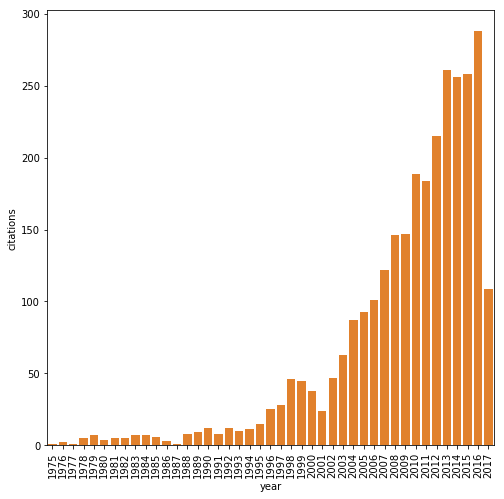

In [191]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

       Fig: Citations of the paper 'Textural Features for 
         Image Classification' (Artificial Intelligence)

In [192]:
pidtod[paperindextoid[2054367]]

'artificial intelligence'

In [193]:
paperidtoname[paperindextoid[2054367]]

'The Concept of a Linguistic Variable and its Application to Approximate Reasoning-I'

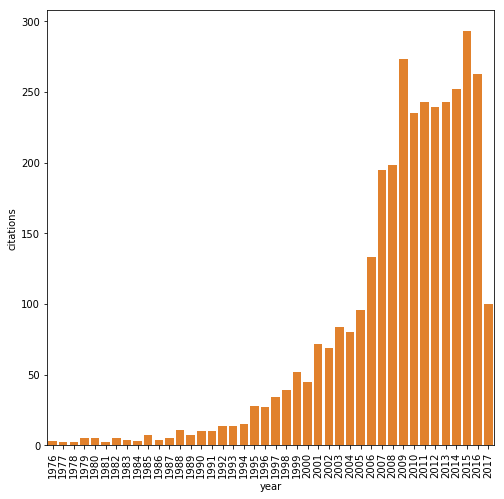

In [194]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[2054367], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)
plt.figure(figsize=(8,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

          Fig: Citations of the paper 'The Concept of 
          a Linguistic Variable and its Application to 
       Approximate Reasoning-I' (Artificial Intelligence)

In [195]:
pidtod[paperindextoid[2046094]]

'communication and security'

In [196]:
paperidtoname[paperindextoid[2046094]]

'New Directions in Cryptography'

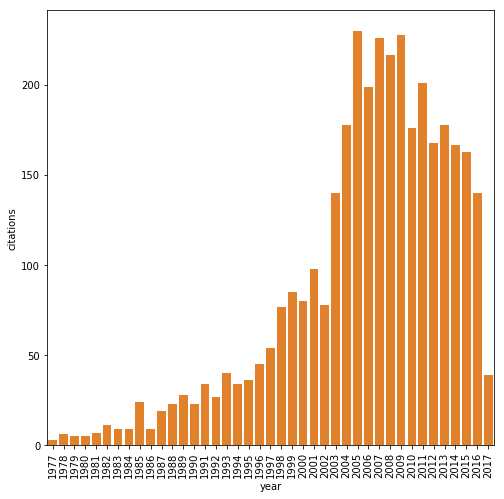

In [197]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[2046094], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)
plt.figure(figsize=(8,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

    Fig: Citations of the paper 'New Directions in Cryptography' 
                (Communication and Security)

In [198]:
pidtod[paperindextoid[711061]]

'communication and security'

In [199]:
paperidtoname[paperindextoid[711061]]

'A method for obtaining digital signatures and public-key cryptosystems'

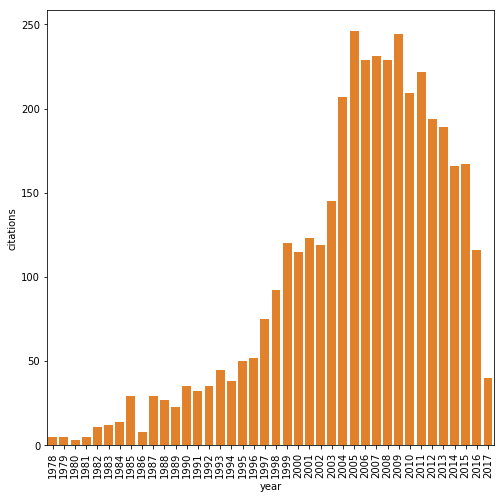

In [200]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[711061], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)
plt.figure(figsize=(8,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

        Fig: Citations of the paper 'A method for obtaining digital
    signatures and public-key cryptosystems' (Communication and Security)

In [201]:
pidtod[paperindextoid[1150683]]

'artificial intelligence'

In [202]:
paperidtoname[paperindextoid[1150683]]

'Paper: Modeling by shortest data description'

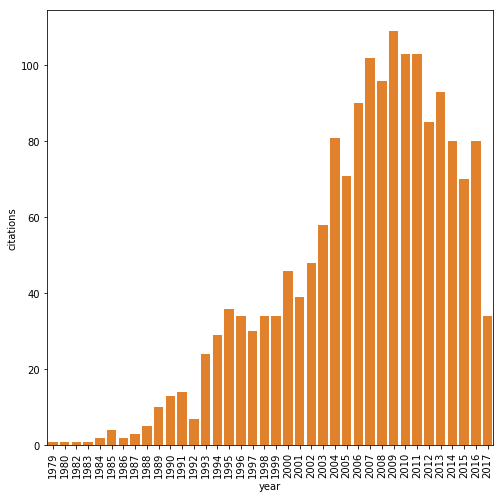

In [203]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[1150683], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)
plt.figure(figsize=(8,8))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

In [66]:
pidtod[paperindextoid[283828]]

'artificial intelligence'

In [67]:
paperidtoname[paperindextoid[283828]]

'Determining optical flow'

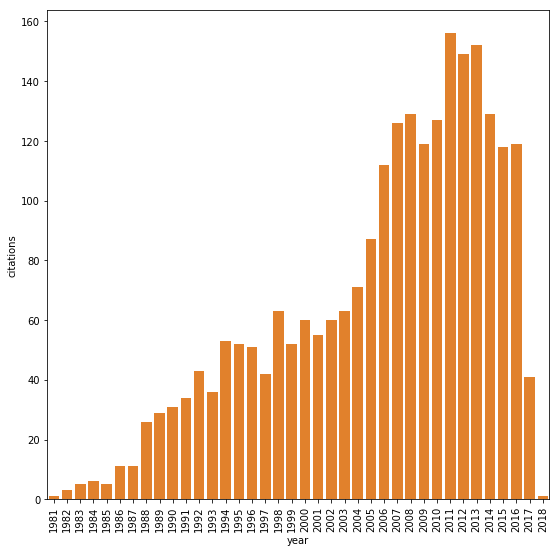

In [68]:
yeartocitations = pd.DataFrame.from_dict(pidtocitationyears[283828], orient='index',columns=['citations']).reset_index().rename(columns={'index': 'year'})
yeartocitations = yeartocitations.sort_values(by=['year'], ascending = True)
plt.figure(figsize=(9,9))
ax = sns.barplot(x=yeartocitations['year'], y=yeartocitations['citations'], palette=["C1"])
plt.xticks(rotation = 90)
plt.show()

In [75]:
pagerank_improv = pd.DataFrame(answer).rename({0:'index',1:'score'}, axis = 1)
pagerank = pd.DataFrame(answer1).rename({0:'index',1:'score'}, axis = 1)

In [150]:
both_pr = pd.merge(pagerank_improv, pagerank, on='index')
both_pr = both_pr.rename(columns={'score_x':'pagerank_improved','score_y':'pagerank'})

In [151]:
temp = both_pr[both_pr['pagerank_improved'] < 0.0000005]
temp = both_pr[both_pr['pagerank'] < 0.0000005]

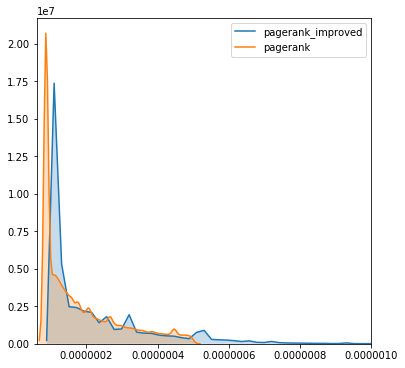

In [205]:
cols = ['pagerank_improved','pagerank']
plt.figure(figsize=(6,6))
plt.xlim(0.00000006, 0.0000010)
for col in cols:
    sns.kdeplot(temp[col], shade=True)
plt.show()

    Fig: Distribution of pagerank scores for 
          original and improved algorithms